In [1]:
import time
import psutil
import os
import nbformat
from nbconvert.preprocessors import ExecutePreprocessor
import csv
from scipy.stats import kruskal, mannwhitneyu
import pandas as pd
import subprocess
import cProfile
import pstats
import threading
import matplotlib.pyplot as plt

In [2]:
class BENCHMARK_VQSVD():
    def __init__(self, script_paths):
        self.script_paths = script_paths  # Lista de scripts a correr
        self.results = {os.path.basename(p): [] for p in script_paths}
        self.all_profiles = []
        self.df_sorted = None

    def monitor_cpu(self, pid, usage_list, interval=0.1):
        try:
            proc = psutil.Process(pid)
            while proc.is_running():
                usage = proc.cpu_percent(interval=interval)
                usage_list.append(usage)
        except psutil.NoSuchProcess:
            pass

    def monitor_ram(self, pid, usage_list, interval=0.1):
        try:
            proc = psutil.Process(pid)
            while proc.is_running():
                usage = proc.memory_info().rss / 1024**2
                usage_list.append(usage)
                time.sleep(interval)
        except psutil.NoSuchProcess:
            pass

    def run_script_and_measure(self, path_to_script, profile_output_path=None):
        print(f"Running: {path_to_script}")
        start_time = time.time()
        cpu_usages = []
        ram_usages = []

        cmd = ["python", "-m", "cProfile", "-o", profile_output_path, path_to_script] if profile_output_path else ["python", path_to_script]
        proc = subprocess.Popen(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

        cpu_thread = threading.Thread(target=self.monitor_cpu, args=(proc.pid, cpu_usages))
        ram_thread = threading.Thread(target=self.monitor_ram, args=(proc.pid, ram_usages))
        cpu_thread.start()
        ram_thread.start()

        proc.wait()
        cpu_thread.join()
        ram_thread.join()

        end_time = time.time()

        return {
            "source": os.path.basename(path_to_script),
            "wall_time": end_time - start_time,
            "cpu_percent": sum(cpu_usages) / len(cpu_usages) if cpu_usages else 0,
            "ram_used_mb": max(ram_usages) if ram_usages else 0,
            "profile_path": profile_output_path if profile_output_path else None
        }

    def run_benchmark(self, iterations):
        for i in range(iterations):
            print(f"\n--- RUN {i+1} ---")
            for script in self.script_paths:
                name = os.path.basename(script)
                profile_path = f"Output/profile/profile_{name.replace('.py','')}_run{i+1}.prof"
                result = self.run_script_and_measure(script, profile_output_path=profile_path)
                self.results[name].append(result)

        self.save_results_to_csv()
        self.save_profile_to_csv(iterations)

    def load_profile_to_dataframe(self, profile_path):
        stats = pstats.Stats(profile_path)
        stats_data = []

        for func, stat in stats.stats.items():
            file_name, line_no, func_name = func
            cc, nc, tt, ct, callers = stat
            stats_data.append({
                "file": file_name,
                "line": line_no,
                "function": func_name,
                "ncalls": nc,
                "tottime": tt,
                "cumtime": ct
            })

        return pd.DataFrame(stats_data)

    def save_profile_to_csv(self, iterations):
        for script in self.script_paths:
            name = os.path.basename(script)
            backend = name.replace(".py", "")
            for i in range(iterations):
                path = f"Output/profile/profile_{backend}_run{i+1}.prof"
                if os.path.exists(path):
                    df = self.load_profile_to_dataframe(path)
                    df["backend"] = backend
                    df["run"] = i + 1
                    self.all_profiles.append(df)

        df_all_profiles = pd.concat(self.all_profiles, ignore_index=True)
        self.df_sorted = df_all_profiles.sort_values(by="cumtime", ascending=False)
        self.df_sorted.to_csv("Output/all_profiles_sorted.csv", index=False)

    def save_results_to_csv(self):
        all_results = []
        for script_name, res_list in self.results.items():
            for res in res_list:
                res["source"] = script_name
                all_results.append(res)
        df = pd.DataFrame(all_results)
        df.to_csv("Output/vqsvd_results.csv", index=False)

    def get_results(self):
        return self.results

    def get_df_sorted(self):
        return self.df_sorted


In [ ]:

scripts = ["solution_clean_paddle.py", "solution_clean_pennylane.py"]
benchmark = BENCHMARK_VQSVD(scripts)
benchmark.run_benchmark(iterations=3)  # puedes cambiar el número de iteraciones si quieres



--- RUN 1 ---
Running: solution_clean_paddle.py
Running: solution_clean_pennylane.py

--- RUN 2 ---
Running: solution_clean_paddle.py
Running: solution_clean_pennylane.py

--- RUN 3 ---
Running: solution_clean_paddle.py
Running: solution_clean_pennylane.py


Averages Pennylane:
wall_time      133.938335
cpu_percent    103.680089
ram_used_mb    801.636719
dtype: float64
Averages Paddle:
wall_time      135.250390
cpu_percent    103.710547
ram_used_mb    795.930990
dtype: float64


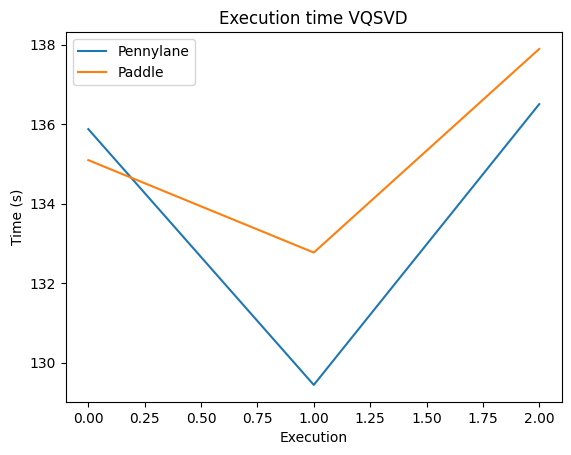

In [12]:
results = benchmark.get_results()
df = pd.DataFrame([entry for script_results in results.values() for entry in script_results])
df_penny = df[df["source"] == "solution_clean_pennylane.py"].reset_index(drop=True)
df_paddle = df[df["source"] == "solution_clean_paddle.py"].reset_index(drop=True)

print("Averages Pennylane:")
print(df_penny[["wall_time", "cpu_percent", "ram_used_mb"]].mean())

print("Averages Paddle:")
print(df_paddle[["wall_time", "cpu_percent", "ram_used_mb"]].mean())

# Plot time
plt.plot(df_penny["wall_time"], label="Pennylane")
plt.plot(df_paddle["wall_time"], label="Paddle")
plt.ylabel("Time (s)")
plt.xlabel("Execution")
plt.title("Execution time VQSVD")
plt.legend()
plt.show()

Kruskal–Wallis

In [15]:
# Comparisons between Paddle and Pennylane

kw_wall_time = kruskal(
    df_paddle["wall_time"],
    df_penny["wall_time"]
)
kw_cpu = kruskal(
    df_paddle["cpu_percent"],
    df_penny["cpu_percent"]
)
kw_ram = kruskal(
    df_paddle["ram_used_mb"],
    df_penny["ram_used_mb"]
)

print("Kruskal–Wallis test results:")
print(f"Wall time p-value: {kw_wall_time.pvalue}")
print(f"CPU % p-value:     {kw_cpu.pvalue}")
print(f"RAM used p-value:  {kw_ram.pvalue}")


Kruskal–Wallis test results:
Wall time p-value: 0.8272593465627116
CPU % p-value:     0.8272593465627116
RAM used p-value:  0.27523352407483126


Post-hoc – Mann–Whitney U (p < 0.05)

In [16]:
mw_wall = mannwhitneyu(
    df_paddle["wall_time"],
    df_penny["wall_time"],
    alternative="two-sided"
)
mw_cpu = mannwhitneyu(
    df_paddle["cpu_percent"],
    df_penny["cpu_percent"],
    alternative="two-sided"
)
mw_ram = mannwhitneyu(
    df_paddle["ram_used_mb"],
    df_penny["ram_used_mb"],
    alternative="two-sided"
)

print("\nMann–Whitney U test results (post-hoc):")
print(f"Wall time p-value: {mw_wall.pvalue}")
print(f"CPU % p-value:     {mw_cpu.pvalue}")
print(f"RAM used p-value:  {mw_ram.pvalue}")



Mann–Whitney U test results (post-hoc):
Wall time p-value: 1.0
CPU % p-value:     1.0
RAM used p-value:  0.4
